In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.distributions as tdist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Set seed
torch.manual_seed(0)

# Where to add a new import
from torch.optim.lr_scheduler import StepLR

## Semi-Discrete Case

Consider Kantorovich dual between measures $\alpha$ and $\beta$ in the case where one of the measures, $\beta$, without loss of generality, is a discrete measure. Hence:
\begin{align}
    \beta(\cdot) &= \sum_{j=1}^m b_j\delta_{y_j}(\cdot)
\end{align}
for some atoms $\{y_j\}_{j=1}^M$ and weights $\{b_j\}_{j=1}^m$ such that $\sum_j b_j =1$, $b_j\in \mathbb{R}^+$ and $y_j\in \mathcal{Y}$ $\forall j$.

Under this discrete measure, the objective $\mathcal{E}$ in dual problem may be re-written:
\begin{align}
    \mathcal{E}(f,g) &= \int_\mathcal{X}f(x)d\alpha(x) + \sum_{j=1}^m b_jg_j + \min_{\mathcal{X} \otimes \mathcal{Y}} (c-f \oplus g)
\end{align}
where $g_j = g(y_j)$ and using the $c$-transform, the objective becomes:
\begin{align}
    \mathcal{E}(g) &=  \int_\mathcal{X}g^{\bar{c}}(x)d\alpha(x) + \sum_{j=1}^m b_jg_j + \min_{\mathcal{X} \otimes \mathcal{Y}} (c-g^{\bar{c}} \oplus g)\\
    &=  \int_\mathcal{X} \min_{j}\{c(x,y_j)-g_j\}d\alpha(x) + \sum_{j=1}^m b_jg_j + \min_{x \in \mathcal{X}, j\in [m]} \left\{c(x,y_j)- g_j- \min_{k}\{c(x,y_k)-g_k\}\right\}
\end{align} where $\{g_j\}_j \in \mathbb{R}^m$.

As $j$ is in a finite set $\{1,\ldots,m\}$, support $\mathcal{X}$ of the integral above may be partitioned into so called Laguerre cells, $\{\mathbb{L}_j(g)\}_j$ such that the minimum over $j$ is attained within the cell, as follows:
\begin{align}
   \mathbb{L}_j(g) = \{x \in \mathcal{X}: \forall j' \neq j, c(x,y_j) - g_j \leq c(x, y_{j'})-g_{j'}\}
\end{align}
Hence the objective may again be rewritten:
\begin{align}
    \mathcal{E}(g) = \sum_{j=1}^m\int_{\mathbb{L}_j(g)} c(x,y_j)-g_j d\alpha(x)+ \sum_{j=1}^m b_jg_j
\end{align}
\noindent The benefit of this construction is that the objective is defined on a finite ($m$) dimensional support $\{g_j\}_j\in \mathbb{R}^m$, and hence the gradient with respect to $g_j$ for $x \in \mathbb{L}_j(g)$ may be written:
\begin{align}
    \nabla \mathcal{E}(g_j) &= -  \int _{\mathbb{L}_j(g)}d\alpha + b_j\\
    &= b_j -\alpha(\mathbb{L}_j(g))
\end{align}
which may be used to minimise the objective using samples from measure $\alpha$ with stochastic gradient descent, or more precisely ascent in this case.

## Entropic Regularisation
One may replace the $\min$ operation in the $c$-transform with the soft-min function $\min_\epsilon$ for some $\epsilon>0$. Note that the soft-min and $\min$ functions coincide at $\epsilon=0$.

\begin{align}
    \min_\epsilon ( S(x,y)) = - \epsilon \int e^{\frac{-S(x,y)}{\epsilon}}d\alpha(x)d\beta(y)
\end{align}

\noindent The relaxed objective in the discrete case then becomes:
\begin{align}
    \mathcal{E}^\epsilon(g) = \int_\mathcal{X}-\epsilon \sum_{j=1}^m e^{\frac{-c(x,y_j)+g_j}{\epsilon}} + \sum_{j=1}^m b_jg_j
\end{align}
\noindent with gradient:
\begin{align}
    \nabla\mathcal{E}^\epsilon(g_j) = -\int_\mathcal{X}\chi^\epsilon_j(x)d\alpha(x)+b_j
\end{align}
where $\chi^\epsilon_j = \frac{e^{\frac{-c(x,y_j)+g_j}{\epsilon}}}{\sum_{k=1}^m e^{\frac{-c(x,y_k)+g_k}{\epsilon}}}$. This may again be used within a stochastic gradient descent scheme.

## Quantization Problem
Consider an extension to the semi-discrete transport problem described above, where, in addition, one would like to learn the discrete distribution $\beta(\cdot) = \sum_{j=1}^m b_j\delta_{y_j}(\cdot) $ by learning the finite dimensional vectors $\{b_j\}_j \in [0,1]^m$ and $\{y_j\}_j \in \mathcal{Y}^m$. This may be written as an optimisation:
\begin{align}
    \min_{\{b_j\}_j \in [0,1]^m, \{y_j\}_j \in \mathcal{Y}^m} \mathcal{L}_c(\alpha, g) = \min_{\{b_j\}_j \in [0,1]^m, \{y_j\}_j \in \mathcal{Y}^m} \max_{g \in \mathbb{R}^m} \mathcal{E}^\epsilon(g)
\end{align}
 One may also simplify the quantization problem to treat each atom with $y_j$ with uniform weight, so $b_j = \frac{1}{m}$ and:
 \begin{align}
    \min_{\{y_j\}_j \in \mathcal{Y}^m} \mathcal{L}_c(\alpha, g) = \min_{\{b_j\}_j \in [0,1]^m, \{y_j\}_j \in \mathcal{Y}^m} \max_{g \in \mathbb{R}^m} \mathcal{E}^\epsilon(g)
\end{align}

In [15]:
n_iters = 10000
n_sub_iters = 10
batch_size = 1 
num_atoms = 4

In [16]:
normal_dist = tdist.MultivariateNormal(torch.tensor([0.,0.]), torch.tensor([[1.,0.],[0.,1.]]))

In [17]:
def l2_cost(x,y):
    return torch.sqrt(torch.sum((x-y)**2, axis=1)).squueze()

In [5]:
def er_chi_unnorm(x,yj,gj, epsilon, cost_func=l2_cost):
    return torch.exp((-cost_func(x,yj)+gj)/epsilon)

In [6]:
def er_chi(x, y, g, epsilon, cost_func=l2_cost):
    chis = er_chi_unnorm(x,y,g,epsilon, cost_func)
    return chis/ torch.sum(chis)

In [7]:
# entropic reg c-transform
def er_ctran(x, g, y, epsilon, cost_func):
    return -epsilon * torch.log(torch.sum(torch.exp((-cost_func(x,y)+g)/epsilon)/torch.tensor(num_atoms))) + torch.sum(g)/torch.tensor(num_atoms)

In [8]:
# init vectors
y = torch.tensor(4.*(-0.5+np.random.random(size=(num_atoms,2))), requires_grad = True)
g = torch.tensor(np.random.random(size=num_atoms), requires_grad = True)
b = torch.ones(num_atoms)/ torch.tensor(num_atoms)
epsilon = torch.tensor(.1)

In [9]:
y

tensor([[-1.4991,  0.6739],
        [-1.6761, -1.3324],
        [-1.7031, -0.2573],
        [-0.8643,  0.0354]], dtype=torch.float64, requires_grad=True)

In [10]:
y

tensor([[-1.4991,  0.6739],
        [-1.6761, -1.3324],
        [-1.7031, -0.2573],
        [-0.8643,  0.0354]], dtype=torch.float64, requires_grad=True)

## INSTANTIATE OPTIMIZER CLASS

In [11]:
learning_rate = 0.1
optimizer_atoms = torch.optim.SGD([y], lr=learning_rate, momentum=0.9, nesterov=True)
optimizer_map = torch.optim.SGD([g], lr=learning_rate, momentum=0.9, nesterov=True)

## INSTANTIATE STEP LEARNING SCHEDULER CLASS

In [12]:
# step_size: at how many multiples of epoch you decay
# new_lr = lr*gamma 

# gamma = decaying factor
scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.1)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.1)



# TRAIN TRANSPORT MAP

In [13]:
for i in range(n_iters):
    x = normal_dist.sample()

    # Clear gradients w.r.t. parameters
    optimizer_map.zero_grad()

    # Get dual objective to maximise
    dual_objective = er_ctran(x, g, y, epsilon, l2_cost)
    map_loss = -dual_objective

    # Getting gradients w.r.t. parameters
    map_loss.backward()
    optimizer_map.step()
    
    # Updating parameters
    if i % 250 == 0:
        scheduler_map.step()
        

# PLOT OUTPUT

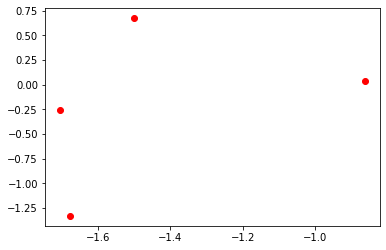

In [14]:
# Plot y atoms
ys = y.detach().numpy()
plt.plot(ys[:,0],ys[:,1], 'ro')

In [15]:
plot_ys = []
plot_xs = []
chis = []
num_points = 1000

for _ in range(num_points):
    x = normal_dist.sample()
    chis.append(er_chi(x, y, g, epsilon).detach().numpy())
    plot_xs.append(x.numpy())
    
ys = y.detach().numpy()
plot_xs = np.array(plot_xs)
chis = np.array(chis)
allocations = np.argmax(chis, axis=1)

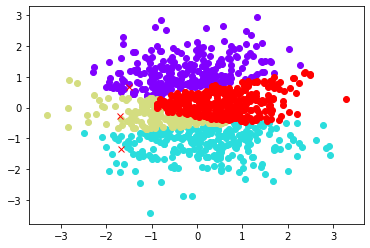

In [16]:
colors = cm.rainbow(np.linspace(0, 1, num_atoms))
for atom_idx in range(num_atoms):
    view = allocations==atom_idx
    plt.scatter(plot_xs[view,0], plot_xs[view,1], color=colors[atom_idx])
    plt.plot(ys[atom_idx,0],ys[atom_idx,1], 'rx')
plt.show()

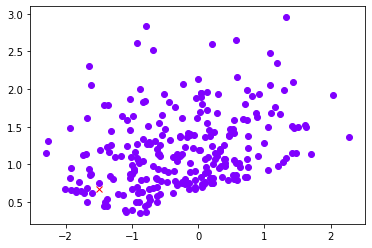

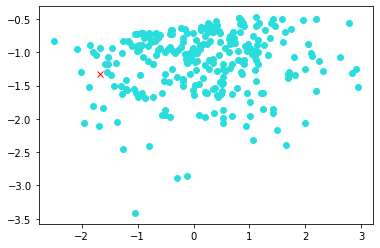

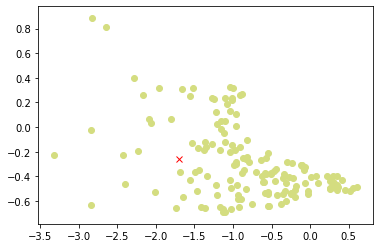

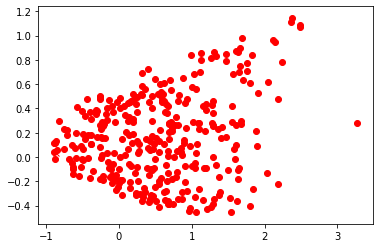

In [17]:
colors = cm.rainbow(np.linspace(0, 1, num_atoms))
for atom_idx in range(num_atoms):
    view = allocations==atom_idx
    plt.scatter(plot_xs[view,0], plot_xs[view,1], color=colors[atom_idx])
    plt.plot(ys[atom_idx,0],ys[atom_idx,1], 'rx')
    plt.show()

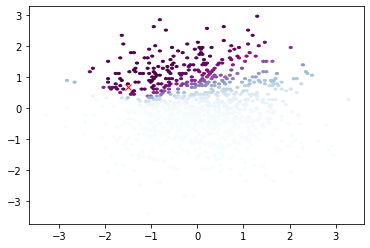

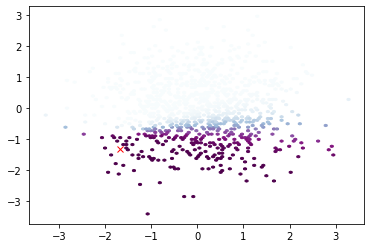

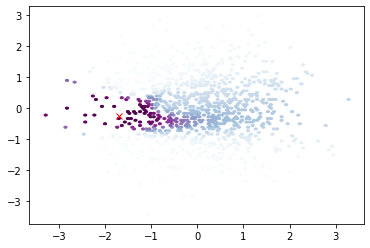

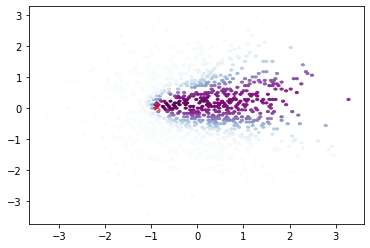

In [18]:
for j in range(num_atoms):
    plt.plot(ys[j,0],ys[j,1], 'rx')
    plt.hexbin(plot_xs[:,0], plot_xs[:,1], chis[:,j], cmap=plt.cm.BuPu)
    plt.show()

##  RE-INIT and TRAIN MODEL

In [19]:
n_iters = 100000
n_sub_iters = 10
multiplier = 5
num_atoms = 20
dim = 2

# init vectors
y = torch.tensor(10*(-0.5+np.random.random(size=(num_atoms,dim))), requires_grad = True)
g = torch.tensor(np.random.random(size=num_atoms), requires_grad = True)
b = torch.ones(num_atoms)/ torch.tensor(num_atoms)
epsilon = torch.tensor(2.)

# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.SGD([y], lr=learning_rate, momentum=0.9, nesterov=True)
optimizer_map = torch.optim.SGD([g], lr=learning_rate, momentum=0.9, nesterov=True)

scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.8)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.8)


### Min Max Optimization

In [25]:
atoms_loss = er_ctran(x, g, y, epsilon, l2_cost)

In [26]:
atoms_loss

tensor(0.8507, dtype=torch.float64, grad_fn=<AddBackward0>)

In [31]:
g

tensor([0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440,
        0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440, 0.5440,
        0.5440, 0.5440], dtype=torch.float64, requires_grad=True)

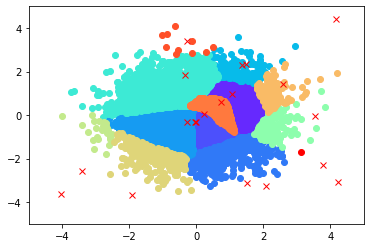

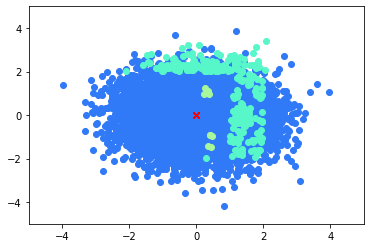

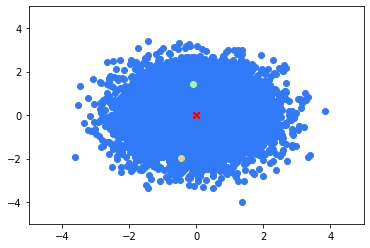

KeyboardInterrupt: 

In [20]:
for i in range(n_iters):
    for _ in range(n_sub_iters):
        # sample x
        x = normal_dist.sample()

        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = er_ctran(x, g, y, epsilon, l2_cost)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()
        
    for _ in range(multiplier*n_sub_iters):
        # sample x
        x = normal_dist.sample()

        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = er_ctran(x, g, y, epsilon, l2_cost)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % 100 == 0:
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
    
    if i % 10**3 == 0:
        plot_ys = []
        plot_xs = []
        chis = []
        num_points = 10000

        for _ in range(num_points):
            x = normal_dist.sample()
            chis.append(er_chi(x, y, g, epsilon).detach().numpy())
            plot_xs.append(x.numpy())

        ys = y.detach().numpy()
        plot_xs = np.array(plot_xs)
        chis = np.array(chis)
        allocations = np.argmax(chis, axis=1)

        colors = cm.rainbow(np.linspace(0, 1, num_atoms))
        for atom_idx in range(num_atoms):
            view = allocations==atom_idx
            plt.scatter(plot_xs[view,0], plot_xs[view,1], color=colors[atom_idx])
            plt.plot(ys[atom_idx,0],ys[atom_idx,1], 'rx')
        plt.xlim(-5,5)
        plt.ylim(-5,5)
        plt.show()

In [ ]:
# Plot y atoms
ys = y.detach().numpy()
plt.plot(ys[:,0],ys[:,1], 'ro')

In [ ]:
plt.hist(ys[:,0]), plt.hist(ys[:,1])

In [ ]:
plot_ys = []
plot_xs = []
chis = []
num_points = 5000

for _ in range(num_points):
    x = normal_dist.sample()
    chis.append(er_chi(x, y, g, epsilon).detach().numpy())
    plot_xs.append(x.numpy())
    
ys = y.detach().numpy()
plot_xs = np.array(plot_xs)
chis = np.array(chis)
allocations = np.argmax(chis, axis=1)

colors = cm.rainbow(np.linspace(0, 1, num_atoms))
for atom_idx in range(num_atoms):
    view = allocations==atom_idx
    plt.scatter(plot_xs[view,0], plot_xs[view,1], color=colors[atom_idx])
    plt.plot(ys[atom_idx,0],ys[atom_idx,1], 'rx')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [ ]:
y